# 🦷 Teeth Segmentation and Whitening Pipeline

Complete pipeline for automatic teeth segmentation using U-Net and intelligent whitening algorithm.

## Pipeline Overview:
1. **Setup & Dependencies** - Install packages and configure parameters
2. **Data Processing** - Extract dataset and create training data
3. **Model Architecture** - Build U-Net for segmentation
4. **Training Pipeline** - Train the segmentation model
5. **Whitening Algorithm** - Apply intelligent teeth whitening
6. **Complete Pipeline** - End-to-end processing and results

## 1. Setup and Dependencies

Install required packages and set up all configuration parameters in one place.

In [ ]:
print("Installing required libraries...")
!uv pip install -r requirements.txt


Installing required libraries...



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ All libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


### If running on colab

In [ ]:
folder_path=None
data_path=None

In [ ]:
from google.colab import drive
import os
# Mount Drive
drive.mount('/content/drive')

# Path to your folder inside Drive
folder_path = "/content/drive/My Drive/teeth-segmentation/processed_data"

# Check contents
os.listdir(folder_path)


In [8]:

# Import all necessary libraries
import os
import json
import shutil
import warnings
import random
warnings.filterwarnings('ignore')

# Scientific computing and image processing
import numpy as np
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam, lr_scheduler

# Visualization
import matplotlib.pyplot as plt

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


In [ ]:
# Configuration - All parameters in one place for easy modification
print("🔧 Setting up configuration...")

# === PATHS (MODIFY THESE FOR YOUR ENVIRONMENT) ===
BASE_DATA_PATH = data_path if folder_path else 'dentalai-DatasetNinja'  # Where dataset will be extracted
PROCESSED_DATA_PATH = folder_path if folder_path else 'content/processed_data/processed_data'  # Where to save processed data
MODEL_SAVE_DIR = 'models/'  # Where to save trained models
RESULTS_DIR = 'test_results/'  # Where to save final results
# === DATASET PARAMETERS ===
TARGET_CLASS = 'Tooth'  # Class name to segment from JSON annotations
IMAGE_SIZE = 256  # Input image size (256x256)

# === TRAINING PARAMETERS ===
BATCH_SIZE = 32  # Batch size for training
NUM_EPOCHS = 30  # Number of training epochs
LEARNING_RATE = 1e-4  # Learning rate for optimizer
WEIGHT_DECAY = 1e-5  # L2 regularization
NUM_WORKERS = 2  # Number of data loading workers
EARLY_STOPPING_PATIENCE = 8  # Stop training if no improvement

# === MODEL PARAMETERS ===
INPUT_CHANNELS = 3  # RGB input
OUTPUT_CHANNELS = 1  # Binary segmentation
USE_BILINEAR = True  # Use bilinear upsampling vs transposed conv

# === WHITENING PARAMETERS ===
LIGHTNESS_INCREASE = 40  # How much to increase brightness
YELLOWNESS_DECREASE = 25  # How much to reduce yellow tint
BLUR_KERNEL_SIZE = (21, 21)  # Gaussian blur for smooth blending
MASK_THRESHOLD = 127  # Threshold for mask binarization

# === DEVICE CONFIGURATION ===
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create necessary directories
for directory in [PROCESSED_DATA_PATH, MODEL_SAVE_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)

print(f"✅ Configuration complete:")
print(f"   Device: {DEVICE}")
print(f"   Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Training epochs: {NUM_EPOCHS}")

🔧 Setting up configuration...
✅ Configuration complete:
   Device: cpu
   Image size: 256x256
   Batch size: 32
   Learning rate: 0.0001
   Training epochs: 30


Dataset found at /content/drive/My Drive/teeth-segmentation/processed_data
Processing dental dataset for teeth segmentation...
Processed data already exists. Use re_calculate=True to reprocess.
   train: 1989 samples
   val: 254 samples
   test: 250 samples
Total existing: 2493 samples
Visualizing 3 sample results...
Sample 1: 800,726 teeth pixels (4.0%)
Sample 2: 11,691 teeth pixels (23.1%)
Sample 3: 11,473 teeth pixels (22.8%)


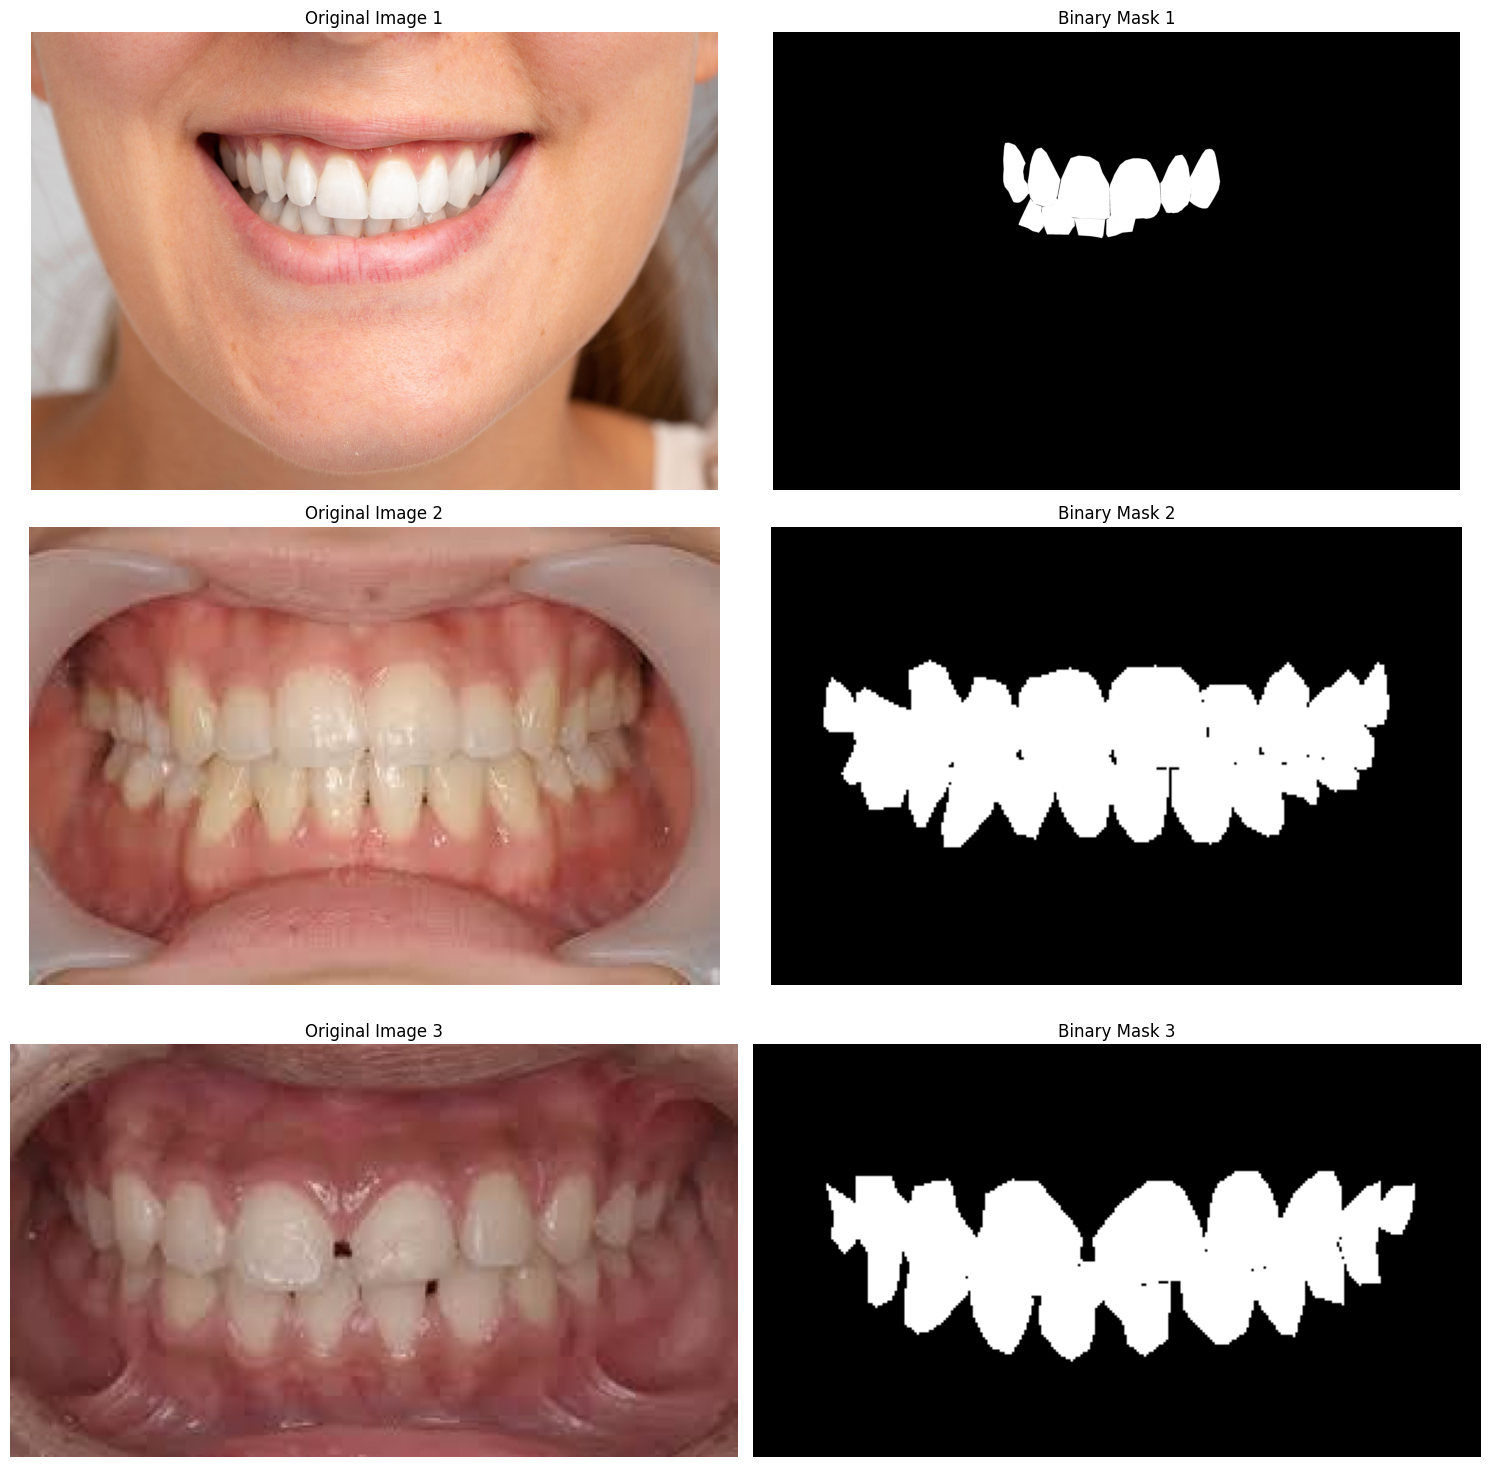

Visualization complete!
Final Result: 2493 samples ready for training
Tip: Use preprocess_dataset(re_calculate=True) to reprocess existing data


In [5]:
# Dataset Preprocessing - Fixed Production Version
def create_binary_mask_from_annotation(annotation_path, image_size, target_class):
    try:
        with open(annotation_path, 'r') as f:
            data = json.load(f)

        width, height = image_size
        mask = np.zeros((height, width), dtype=np.uint8)

        objects_found = 0
        for obj in data.get('objects', []):
            class_title = obj.get('classTitle', '')

            if (class_title == target_class or
                class_title.lower() == target_class.lower() or
                target_class.lower() in class_title.lower()):

                objects_found += 1

                points = None
                if 'points' in obj:
                    if 'exterior' in obj['points']:
                        points = obj['points']['exterior']
                    elif isinstance(obj['points'], list):
                        points = obj['points']
                elif 'polygon' in obj:
                    points = obj['polygon']
                elif 'geometry' in obj:
                    if 'coordinates' in obj['geometry']:
                        points = obj['geometry']['coordinates']

                if points and len(points) > 2:
                    try:
                        poly_img = Image.new('L', (width, height), 0)
                        ImageDraw.Draw(poly_img).polygon(
                            [tuple(p) for p in points], outline=1, fill=1
                        )
                        poly_mask = np.array(poly_img)
                        mask = np.maximum(mask, poly_mask)
                    except Exception:
                        continue

        return mask if objects_found > 0 and np.sum(mask) > 0 else None
    except Exception:
        return None

def find_matching_image(annotation_filename, image_directory):
    expected_image_filename = os.path.splitext(annotation_filename)[0]
    expected_image_path = os.path.join(image_directory, expected_image_filename)

    if os.path.exists(expected_image_path):
        return expected_image_path, expected_image_filename

    base_name = os.path.splitext(expected_image_filename)[0]
    for extension in ['.jpg', '.jpeg', '.png', '.bmp']:
        alternative_filename = base_name + extension
        alternative_path = os.path.join(image_directory, alternative_filename)
        if os.path.exists(alternative_path):
            return alternative_path, alternative_filename

    return None, None

def visualize_sample_results(processed_data_path, num_samples=3):
    print(f"Visualizing {num_samples} sample results...")

    train_img_dir = os.path.join(processed_data_path, 'train', 'images')
    train_mask_dir = os.path.join(processed_data_path, 'train', 'masks')

    if not os.path.exists(train_img_dir) or not os.path.exists(train_mask_dir):
        print("No processed data found for visualization")
        return

    image_files = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg', '.png'))][:num_samples]

    if not image_files:
        print("No image files found for visualization")
        return

    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(train_img_dir, img_file)
        mask_file = os.path.splitext(img_file)[0] + '.png'
        mask_path = os.path.join(train_mask_dir, mask_file)

        try:
            # Original image
            original_img = cv2.imread(img_path)
            original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            axes[i, 0].imshow(original_rgb)
            axes[i, 0].set_title(f'Original Image {i+1}')
            axes[i, 0].axis('off')

            # Binary mask
            mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            axes[i, 1].imshow(mask_img, cmap='gray')
            axes[i, 1].set_title(f'Binary Mask {i+1}')
            axes[i, 1].axis('off')


            # Print stats
            total_pixels = mask_img.shape[0] * mask_img.shape[1]
            teeth_pixels = np.sum(mask_img > 0)
            percentage = (teeth_pixels / total_pixels) * 100

            print(f"Sample {i+1}: {teeth_pixels:,} teeth pixels ({percentage:.1f}%)")

        except Exception as e:
            print(f"Error visualizing sample {i+1}: {e}")
            for j in range(2):
                axes[i, j].text(0.5, 0.5, 'Error', ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()
    print("Visualization complete!")

def preprocess_dataset(re_calculate=False):
    print("Processing dental dataset for teeth segmentation...")

    if os.path.exists(PROCESSED_DATA_PATH):
        if re_calculate:
            print("Re-calculating: Removing existing processed data...")
            shutil.rmtree(PROCESSED_DATA_PATH)
        else:
            print("Processed data already exists. Use re_calculate=True to reprocess.")

            # Count existing samples
            total_existing = 0
            for split in ['train', 'val', 'test']:
                img_dir = os.path.join(PROCESSED_DATA_PATH, split, 'images')
                if os.path.exists(img_dir):
                    count = len([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))])
                    total_existing += count
                    print(f"   {split}: {count} samples")

            print(f"Total existing: {total_existing} samples")

            # Show visualization
            visualize_sample_results(PROCESSED_DATA_PATH, num_samples=3)

            return total_existing

    total_processed = 0

    for split in ['train', 'valid', 'test']:
        print(f"Processing {split} split...")

        source_img_dir = os.path.join(BASE_DATA_PATH, split, 'img')
        source_ann_dir = os.path.join(BASE_DATA_PATH, split, 'ann')

        if not os.path.exists(source_img_dir) or not os.path.exists(source_ann_dir):
            print(f"Source directories not found for {split}, skipping...")
            continue

        dest_split_name = 'val' if split == 'valid' else split
        dest_img_dir = os.path.join(PROCESSED_DATA_PATH, dest_split_name, 'images')
        dest_mask_dir = os.path.join(PROCESSED_DATA_PATH, dest_split_name, 'masks')
        os.makedirs(dest_img_dir, exist_ok=True)
        os.makedirs(dest_mask_dir, exist_ok=True)

        annotation_files = [f for f in os.listdir(source_ann_dir) if f.endswith('.json')]
        split_successful = 0
        split_failed = 0

        print(f"Found {len(annotation_files)} annotation files")

        for file_index, annotation_file in enumerate(tqdm(annotation_files, desc=f"Processing {split}")):
            image_path, image_filename = find_matching_image(annotation_file, source_img_dir)

            if not image_path:
                split_failed += 1
                continue

            try:
                with Image.open(image_path) as img:
                    image_size = img.size
            except Exception:
                split_failed += 1
                continue

            annotation_path = os.path.join(source_ann_dir, annotation_file)
            binary_mask = create_binary_mask_from_annotation(annotation_path, image_size, TARGET_CLASS)

            if binary_mask is not None and np.sum(binary_mask) > 0:
                clean_base_name = f"{split}_{file_index+1:04d}"
                image_extension = os.path.splitext(image_filename)[1]
                clean_image_name = clean_base_name + image_extension
                clean_mask_name = clean_base_name + '.png'

                dest_image_path = os.path.join(dest_img_dir, clean_image_name)
                shutil.copy(image_path, dest_image_path)

                mask_image = Image.fromarray((binary_mask * 255).astype(np.uint8))
                dest_mask_path = os.path.join(dest_mask_dir, clean_mask_name)
                mask_image.save(dest_mask_path)

                split_successful += 1
            else:
                split_failed += 1

        print(f"Successfully processed: {split_successful} samples")
        if split_failed > 0:
            print(f"Failed to process: {split_failed} samples")

        total_processed += split_successful

    print(f"Dataset preprocessing completed! Total: {total_processed} samples")

    # Show visualization of results
    if total_processed > 0:
        visualize_sample_results(PROCESSED_DATA_PATH, num_samples=3)

    return total_processed

# Check and run preprocessing
dataset_available = (
    os.path.exists(BASE_DATA_PATH) and
    os.path.exists(os.path.join(BASE_DATA_PATH, 'train'))
)

if dataset_available:
    print(f"Dataset found at {BASE_DATA_PATH}")
    processed_count = preprocess_dataset(re_calculate=False)
    print(f"Final Result: {processed_count} samples ready for training")
    print("Tip: Use preprocess_dataset(re_calculate=True) to reprocess existing data")
else:
    print(f"Dataset not found at {BASE_DATA_PATH}")

## 3. Custom Dataset Class

PyTorch Dataset class for loading images and masks with proper transformations and error handling.

In [ ]:
class TeethDataset(Dataset):
    """Custom dataset for teeth segmentation."""

    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        """
        Initialize dataset.

        Args:
            image_dir: Directory containing images
            mask_dir: Directory containing masks
            image_transform: Transformations for images
            mask_transform: Transformations for masks
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # Get list of image files
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        self.image_files.sort()  # Ensure consistent ordering

        print(f"📚 Dataset loaded: {len(self.image_files)} samples from {image_dir}")

    def __len__(self):
        """Return number of samples."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """Get a single sample (image, mask pair)."""
        # Get image filename and corresponding mask filename
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_filename)

        # Mask always has .png extension
        mask_filename = os.path.splitext(img_filename)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_filename)

        try:
            # Load image and convert to RGB
            image = Image.open(img_path).convert('RGB')

            # Load mask and convert to grayscale
            mask = Image.open(mask_path).convert('L')

            # Convert mask to binary (0 or 1)
            mask_array = np.array(mask, dtype=np.float32) / 255.0
            mask_array = (mask_array > 0.5).astype(np.float32)
            mask = Image.fromarray(mask_array)

            # Apply transformations
            if self.image_transform:
                image = self.image_transform(image)

            if self.mask_transform:
                mask = self.mask_transform(mask)

            return image, mask

        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return dummy tensors as fallback
            dummy_image = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            dummy_mask = torch.zeros(1, IMAGE_SIZE, IMAGE_SIZE)
            return dummy_image, dummy_mask

print("✅ TeethDataset class defined")

✅ TeethDataset class defined


## 4. Attention-U-Net Model Architecture

Complete Attention-U-Net implementation with encoder, decoder, and skip connections for semantic segmentation.

In [ ]:

class DoubleConv(nn.Module):
    """Double convolution with BatchNorm and ReLU"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downsampling: MaxPool -> DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class AttentionGate(nn.Module):
    """Attention Gate for focusing on relevant features"""

    def __init__(self, gate_channels, skip_channels, inter_channels):
        super().__init__()
        self.W_gate = nn.Sequential(
            nn.Conv2d(gate_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )

        self.W_skip = nn.Sequential(
            nn.Conv2d(skip_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip):
        """
        gate: gating signal from coarser scale (decoder)
        skip: skip connection from encoder
        """
        # Resize gate to match skip dimensions if needed
        gate_size = skip.size()[2:]
        gate_resized = F.interpolate(gate, size=gate_size, mode='bilinear', align_corners=True)

        # Apply transformations
        g1 = self.W_gate(gate_resized)
        x1 = self.W_skip(skip)

        # Attention computation
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        # Apply attention to skip connection
        return skip * psi


class AttentionUp(nn.Module):
    """Fixed Upsampling with Attention Gate"""

    def __init__(self, in_channels, skip_channels, out_channels, bilinear=True):
        super().__init__()

        # Upsampling
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Reduce channels after upsampling
            self.up_conv = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
            up_out_ch = in_channels // 2
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.up_conv = None
            up_out_ch = in_channels // 2

        # Attention Gate - FIXED channel dimensions
        self.attention = AttentionGate(
            gate_channels=up_out_ch,        # From upsampled features
            skip_channels=skip_channels,     # From encoder skip connection
            inter_channels=min(up_out_ch, skip_channels) // 2  # Conservative inter channels
        )

        # Final convolution - FIXED input channel calculation
        total_channels = up_out_ch + skip_channels
        self.conv = DoubleConv(total_channels, out_channels)

    def forward(self, x1, x2):
        """
        x1: features from decoder (gating signal)
        x2: features from encoder (skip connection)
        """
        # Upsample x1
        x1 = self.up(x1)
        if self.up_conv is not None:
            x1 = self.up_conv(x1)

        # Handle size differences
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        # Apply attention to skip connection
        x2_attended = self.attention(x1, x2)

        # Concatenate and process
        x = torch.cat([x2_attended, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Output convolution"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class CompactAttentionUNet(nn.Module):
    """Fixed Compact Attention U-Net optimized for teeth segmentation """

    def __init__(self, n_channels=3, n_classes=1, bilinear=True, base_channels=48, depth=4):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_channels = base_channels
        self.depth = depth

        # Input convolution
        self.inc = DoubleConv(n_channels, base_channels)

        # Build encoder layers dynamically
        self.down_layers = nn.ModuleList()
        channel_multipliers = self._get_channel_multipliers()

        for i in range(depth):
            in_ch = base_channels * channel_multipliers[i]
            out_ch = base_channels * channel_multipliers[i + 1]
            self.down_layers.append(Down(in_ch, out_ch))

        # Build FIXED attention decoder layers
        self.attention_up_layers = nn.ModuleList()

        # Calculate decoder channels correctly
        for i in range(depth):
            # Current decoder level (from bottom to top)
            decoder_level = depth - 1 - i

            if i == 0:  # First decoder layer (bottom)
                # Input from bottleneck
                in_ch = base_channels * channel_multipliers[depth]
                # Skip from encoder level depth-1
                skip_ch = base_channels * channel_multipliers[depth - 1]
                # Output channels
                out_ch = skip_ch
            else:
                # Input from previous decoder layer
                in_ch = base_channels * channel_multipliers[depth - i]
                # Skip from encoder
                skip_ch = base_channels * channel_multipliers[decoder_level]
                # Output channels
                if decoder_level == 0:  # Final level
                    out_ch = base_channels
                else:
                    out_ch = skip_ch

            self.attention_up_layers.append(
                AttentionUp(in_ch, skip_ch, out_ch, bilinear)
            )

        # Output convolution
        self.outc = OutConv(base_channels, n_classes)

        # Print architecture details
        self._print_architecture_info(channel_multipliers)

    def _get_channel_multipliers(self):
        """Optimized channel multipliers for <200MB constraint"""
        if self.depth == 4:
            # Reduced multipliers for teeth segmentation efficiency
            return [1, 2, 4, 6, 6]  # Max 288 channels instead of 512
        elif self.depth == 3:
            return [1, 2, 4, 4]
        elif self.depth == 5:
            return [1, 2, 3, 4, 5, 5]  # Conservative growth
        else:
            # Conservative progression for memory efficiency
            multipliers = [1]
            for i in range(self.depth):
                if i < 2:
                    multipliers.append(multipliers[-1] * 2)
                else:
                    multipliers.append(multipliers[-1] + 1)  # Linear growth
            multipliers.append(multipliers[-1])  # Bottleneck same as last
            return multipliers

    def _print_architecture_info(self, channel_multipliers):
        """Print architecture information for teeth segmentation"""
        print(f"🦷 FIXED Compact Attention U-Net for Teeth Segmentation (Depth {self.depth}):")
        print(f"   Base channels: {self.base_channels}")
        print(f"   Bilinear: {self.bilinear}")

        # Show encoder progression
        encoder_channels = [self.base_channels * mult for mult in channel_multipliers]
        print(f"   Encoder: {' -> '.join(map(str, encoder_channels))}")

        # Show fixed decoder details
        print(f"   🔧 FIXED Attention Decoder:")
        for i, up_layer in enumerate(self.attention_up_layers):
            level = self.depth - 1 - i
            print(f"     AttUp{i+1}: Level {level} -> Fixed channel alignment")

    def forward(self, x):
        # Initial convolution
        x_current = self.inc(x)

        # Store skip connections
        skip_connections = [x_current]

        # Encoder path
        for down_layer in self.down_layers:
            x_current = down_layer(x_current)
            skip_connections.append(x_current)

        # Start decoder with bottleneck
        x = skip_connections.pop()

        # Attention decoder path
        for attention_up_layer in self.attention_up_layers:
            skip = skip_connections.pop()
            x = attention_up_layer(x, skip)  # x is gate, skip is skip connection

        # Output convolution
        return self.outc(x)


def calculate_model_parameters(model):
    """Calculate model parameters and attention gate parameters separately"""
    total_params = 0
    attention_params = 0

    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count

        # Count attention gate parameters
        if 'attention' in name:
            attention_params += param_count

    return total_params, attention_params


def debug_model_architecture(model, input_shape=(1, 3, 256, 256)):
    """Debug function to trace tensor shapes through the network"""
    device = next(model.parameters()).device

    print("\n🔍 DEBUGGING MODEL ARCHITECTURE:")
    print("="*60)

    with torch.no_grad():
        x = torch.randn(*input_shape).to(device)
        print(f"Input: {x.shape}")

        # Initial convolution
        x_current = model.inc(x)
        print(f"After inc: {x_current.shape}")

        # Store skip connections and trace encoder
        skip_connections = [x_current]
        print("\nENCODER PATH:")

        for i, down_layer in enumerate(model.down_layers):
            x_current = down_layer(x_current)
            skip_connections.append(x_current)
            print(f"  Down{i+1}: {x_current.shape}")

        print(f"\nBottleneck: {x_current.shape}")

        # Start decoder
        x = skip_connections.pop()
        print(f"Starting decoder with: {x.shape}")

        print("\nDECODER PATH:")
        # Attention decoder path
        for i, attention_up_layer in enumerate(model.attention_up_layers):
            skip = skip_connections.pop()
            print(f"  AttUp{i+1}:")
            print(f"    Gate input: {x.shape}")
            print(f"    Skip input: {skip.shape}")

            try:
                x = attention_up_layer(x, skip)
                print(f"    Output: {x.shape}")
            except Exception as e:
                print(f"    ❌ ERROR: {e}")
                # Print attention gate channel info
                att_gate = attention_up_layer.attention
                print(f"    Debug - Gate conv expects: {att_gate.W_gate[0].in_channels} channels")
                print(f"    Debug - Skip conv expects: {att_gate.W_skip[0].in_channels} channels")
                return False

        # Output convolution
        final_output = model.outc(x)
        print(f"\nFinal output: {final_output.shape}")
        print("✅ Architecture debug completed successfully!")
        return True


# Configuration for teeth segmentation
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 1
USE_BILINEAR = True
BASE_CHANNELS = 48
DEPTH = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize FIXED model
print("🚀 Creating FIXED Compact Attention U-Net...")
model = CompactAttentionUNet(
    n_channels=INPUT_CHANNELS,
    n_classes=OUTPUT_CHANNELS,
    bilinear=USE_BILINEAR,
    base_channels=BASE_CHANNELS,
    depth=DEPTH
).to(DEVICE)

# Debug architecture
debug_success = debug_model_architecture(model)

if debug_success:
    # Calculate parameters
    total_params, attention_params = calculate_model_parameters(model)

    print(f"\n🚀 FIXED Compact Attention U-Net Summary:")
    print(f"   🦷 Optimized for: Teeth segmentation")
    print(f"   📊 Total parameters: {total_params:,}")
    print(f"   🎯 Attention parameters: {attention_params:,} ({100*attention_params/total_params:.1f}%)")



🚀 Creating FIXED Compact Attention U-Net...
🦷 FIXED Compact Attention U-Net for Teeth Segmentation (Depth 4):
   Base channels: 48
   Bilinear: True
   Encoder: 48 -> 96 -> 192 -> 288 -> 288
   🔧 FIXED Attention Decoder:
     AttUp1: Level 3 -> Fixed channel alignment
     AttUp2: Level 2 -> Fixed channel alignment
     AttUp3: Level 1 -> Fixed channel alignment
     AttUp4: Level 0 -> Fixed channel alignment

🔍 DEBUGGING MODEL ARCHITECTURE:
Input: torch.Size([1, 3, 256, 256])
After inc: torch.Size([1, 48, 256, 256])

ENCODER PATH:
  Down1: torch.Size([1, 96, 128, 128])
  Down2: torch.Size([1, 192, 64, 64])
  Down3: torch.Size([1, 288, 32, 32])
  Down4: torch.Size([1, 288, 16, 16])

Bottleneck: torch.Size([1, 288, 16, 16])
Starting decoder with: torch.Size([1, 288, 16, 16])

DECODER PATH:
  AttUp1:
    Gate input: torch.Size([1, 288, 16, 16])
    Skip input: torch.Size([1, 288, 32, 32])
    Output: torch.Size([1, 288, 32, 32])
  AttUp2:
    Gate input: torch.Size([1, 288, 32, 32])
    

## 5. Data Loaders and Transforms

Set up data augmentation, normalization, and data loaders for training, validation, and testing.

In [ ]:
# Enhanced Data Transforms with Essential Dental Imaging Augmentations

class AdaptiveColorJitter:
    """
    Advanced color jittering specifically designed for dental imaging.
    Simulates different lighting conditions commonly found in dental photography.
    """

    def __init__(self, brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05, p=0.7):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.p = p

    def __call__(self, image):
        if random.random() > self.p:
            return image

        # Apply progressive color transformations
        # 1. Brightness variation (dental lighting changes)
        brightness_factor = random.uniform(1 - self.brightness, 1 + self.brightness)
        image = TF.adjust_brightness(image, brightness_factor)

        # 2. Contrast adjustment (camera exposure differences)
        contrast_factor = random.uniform(1 - self.contrast, 1 + self.contrast)
        image = TF.adjust_contrast(image, contrast_factor)

        # 3. Saturation changes (color temperature variations)
        saturation_factor = random.uniform(1 - self.saturation, 1 + self.saturation)
        image = TF.adjust_saturation(image, saturation_factor)

        # 4. Subtle hue shifts (white balance variations)
        hue_factor = random.uniform(-self.hue, self.hue)
        image = TF.adjust_hue(image, hue_factor)

        return image


class RandomNoise:
    """
    Add realistic camera sensor noise to improve model robustness.
    Simulates digital noise commonly found in dental photography.
    """

    def __init__(self, noise_factor=0.02, p=0.3):
        self.noise_factor = noise_factor
        self.p = p

    def __call__(self, tensor):  
        if torch.rand(1) < self.p:
            # Add Gaussian noise
            noise = torch.randn_like(tensor) * self.noise_factor
            # Clamp to valid range
            return torch.clamp(tensor + noise, 0, 1)
        return tensor


class RandomBlur:
    """
    Apply random Gaussian blur to simulate focus variations.
    Common in handheld dental photography.
    """

    def __init__(self, kernel_sizes=[3, 5], sigma_range=(0.1, 0.6), p=0.25):
        self.kernel_sizes = kernel_sizes
        self.sigma_range = sigma_range
        self.p = p

    def __call__(self, image):
        if random.random() > self.p:
            return image

        # Random kernel size (must be odd)
        kernel_size = random.choice(self.kernel_sizes)

        # Random sigma value
        sigma = random.uniform(self.sigma_range[0], self.sigma_range[1])

        return TF.gaussian_blur(image, kernel_size, sigma)


def get_train_transforms():
    """
    Essential data augmentation pipeline for dental segmentation.
    Focuses on realistic variations commonly found in dental imaging.
    """
    return transforms.Compose([
        # 1. Resize to target dimensions
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=TF.InterpolationMode.BILINEAR),

        # 2. Horizontal flip (dental symmetry)
        transforms.RandomHorizontalFlip(p=0.5),

        # 3. Advanced color augmentation for dental lighting
        AdaptiveColorJitter(
            brightness=0.20,  # Dental light variations
            contrast=0.20,    # Camera exposure differences
            saturation=0.15,  # Color temperature changes
            hue=0.03,        # Subtle white balance shifts
            p=0.5            # Apply frequently
        ),

        # 4. Focus simulation
        RandomBlur(
            kernel_sizes=[3, 5],          # Blur kernel options
            sigma_range=(0.05, 0.3),       # Blur intensity range
            p=0.2                         # Occasional application
        ),

        # 5. Convert to tensor
        transforms.ToTensor(),

        # 6. Add realistic sensor noise
        RandomNoise(noise_factor=0.01, p=0.20),

        # 7. Normalize using ImageNet statistics
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])


def get_validation_transforms():
    """
    Validation transforms - no augmentation for consistent evaluation.
    """
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


def get_mask_transforms():
    """
    Mask transforms - preserve exact pixel values using nearest neighbor.
    """
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=TF.InterpolationMode.NEAREST),
        transforms.ToTensor()
    ])

# Create transforms
train_img_transform = get_train_transforms()
val_img_transform = get_validation_transforms()
mask_transform = get_mask_transforms()

print("🔄 Creating datasets and data loaders...")

# Create datasets
train_dataset = TeethDataset(
    image_dir=os.path.join(PROCESSED_DATA_PATH, 'train', 'images'),
    mask_dir=os.path.join(PROCESSED_DATA_PATH, 'train', 'masks'),
    image_transform=train_img_transform,
    mask_transform=mask_transform
)

val_dataset = TeethDataset(
    image_dir=os.path.join(PROCESSED_DATA_PATH, 'val', 'images'),
    mask_dir=os.path.join(PROCESSED_DATA_PATH, 'val', 'masks'),
    image_transform=val_img_transform,
    mask_transform=mask_transform
)

test_dataset = TeethDataset(
    image_dir=os.path.join(PROCESSED_DATA_PATH, 'test', 'images'),
    mask_dir=os.path.join(PROCESSED_DATA_PATH, 'test', 'masks'),
    image_transform=val_img_transform,
    mask_transform=mask_transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle training data
    num_workers=NUM_WORKERS,
    pin_memory=True  # Faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"📊 Data loaders created:")
print(f"   Training: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"   Validation: {len(val_dataset)} samples, {len(val_loader)} batches")
print(f"   Test: {len(test_dataset)} samples, {len(test_loader)} batches")
print(f"   Batch size: {BATCH_SIZE}")

🔄 Creating datasets and data loaders...
📚 Dataset loaded: 1989 samples from /content/drive/My Drive/teeth-segmentation/processed_data/train/images
📚 Dataset loaded: 254 samples from /content/drive/My Drive/teeth-segmentation/processed_data/val/images
📚 Dataset loaded: 250 samples from /content/drive/My Drive/teeth-segmentation/processed_data/test/images
📊 Data loaders created:
   Training: 1989 samples, 63 batches
   Validation: 254 samples, 8 batches
   Test: 250 samples, 8 batches
   Batch size: 32


## 6. Loss Functions and Training Setup

Define loss functions (BCE + Dice), optimizer, scheduler, and training utilities.

In [ ]:
class DiceLoss(nn.Module):
    """Dice Loss for segmentation tasks."""

    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        # Flatten tensors
        pred_flat = predictions.view(-1)
        target_flat = targets.view(-1)

        # Calculate Dice coefficient
        intersection = (pred_flat * target_flat).sum()
        total = pred_flat.sum() + target_flat.sum()
        dice = (2.0 * intersection + self.smooth) / (total + self.smooth)

        # Return Dice loss (1 - Dice coefficient)
        return 1.0 - dice


class CombinedLoss(nn.Module):
    """Combined BCE + Dice Loss."""

    def __init__(self, bce_weight=1.0, dice_weight=1.0):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

        # BCE with logits (includes sigmoid)
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()

    def forward(self, logits, targets):
        # Calculate BCE loss
        bce = self.bce_loss(logits, targets)

        # Calculate Dice loss (need probabilities)
        probs = torch.sigmoid(logits)
        dice = self.dice_loss(probs, targets)

        # Combine losses
        total_loss = self.bce_weight * bce + self.dice_weight * dice
        return total_loss


def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculate segmentation metrics."""
    # Convert to binary predictions
    binary_preds = (predictions > threshold).float()

    # Flatten tensors
    pred_flat = binary_preds.view(-1)
    target_flat = targets.view(-1)

    # Calculate metrics
    intersection = (pred_flat * target_flat).sum().item()
    pred_sum = pred_flat.sum().item()
    target_sum = target_flat.sum().item()
    union = pred_sum + target_sum - intersection

    # Avoid division by zero
    smooth = 1e-6

    # Dice coefficient
    dice = (2.0 * intersection + smooth) / (pred_sum + target_sum + smooth)

    # IoU (Intersection over Union)
    iou = (intersection + smooth) / (union + smooth)

    # Pixel accuracy
    correct = (pred_flat == target_flat).sum().item()
    total = pred_flat.numel()
    pixel_acc = correct / total

    return {
        'dice': dice,
        'iou': iou,
        'pixel_accuracy': pixel_acc
    }


# Initialize training components
print("🔧 Setting up training components...")

# Loss function
criterion = CombinedLoss(bce_weight=1.0, dice_weight=1.0)

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"   ✅ Loss: Combined BCE + Dice")
print(f"   ✅ Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"   ✅ Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")

🔧 Setting up training components...
   ✅ Loss: Combined BCE + Dice
   ✅ Optimizer: Adam (lr=0.0001, weight_decay=1e-05)
   ✅ Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## 7. Training and Validation Functions

Complete training pipeline with proper train/validation loops and model checkpointing.

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train model for one epoch."""
    model.train()

    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    num_batches = len(train_loader)

    # Progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for batch_idx, (images, masks) in enumerate(pbar):
        # Move data to device
        images = images.to(device, dtype=torch.float32)
        masks = masks.to(device, dtype=torch.float32)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(images)
        loss = criterion(logits, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate metrics
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            metrics = calculate_metrics(probs, masks)

            total_loss += loss.item()
            total_dice += metrics['dice']
            total_iou += metrics['iou']

        # Update progress bar
        pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Dice': f"{metrics['dice']:.4f}",
            'IoU': f"{metrics['iou']:.4f}"
        })

    # Return average metrics
    return {
        'loss': total_loss / num_batches,
        'dice': total_dice / num_batches,
        'iou': total_iou / num_batches
    }


def validate_epoch(model, val_loader, criterion, device, epoch):
    """Validate model for one epoch."""
    model.eval()

    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    num_batches = len(val_loader)

    # Progress bar
    pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(pbar):
            # Move data to device
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            # Forward pass
            logits = model(images)
            loss = criterion(logits, masks)

            # Calculate metrics
            probs = torch.sigmoid(logits)
            metrics = calculate_metrics(probs, masks)

            total_loss += loss.item()
            total_dice += metrics['dice']
            total_iou += metrics['iou']

            # Update progress bar
            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Dice': f"{metrics['dice']:.4f}",
                'IoU': f"{metrics['iou']:.4f}"
            })

    # Return average metrics
    return {
        'loss': total_loss / num_batches,
        'dice': total_dice / num_batches,
        'iou': total_iou / num_batches
    }


def save_checkpoint(model, optimizer, epoch, metrics, is_best=False):
    """Save model checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics
    }

    # Save regular checkpoint
    checkpoint_path = os.path.join(MODEL_SAVE_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save(checkpoint, checkpoint_path)

    # Save best model
    if is_best:
        best_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')
        torch.save(checkpoint, best_path)
        print(f"✨ New best model saved! Val Loss: {metrics['loss']:.4f}, Val Dice: {metrics['dice']:.4f}")


print("✅ Training and validation functions defined")

✅ Training and validation functions defined


### To Resume Training from last checkpoint

In [ ]:
def load_checkpoint(checkpoint_path, model, optimizer=None, device='cuda'):
    """Load model + optimizer (optional) from checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Restore model weights
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore optimizer (if continuing training)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Resume from saved epoch
    start_epoch = checkpoint['epoch'] + 1
    metrics = checkpoint['metrics']

    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']} "
          f"(loss: {metrics['loss']:.4f}, dice: {metrics['dice']:.4f})")

    return model, optimizer, start_epoch, metrics


checkpoint_path = os.path.join(MODEL_SAVE_DIR, "best_model.pth")
# model, optimizer, start_epoch, metrics = load_checkpoint(checkpoint_path, model, optimizer, DEVICE)


In [12]:
def train_model():
    """Main training loop."""
    print("🚀 Starting model training...")
    print(f"Training for {NUM_EPOCHS} epochs on {DEVICE}")
    print("=" * 60)

    best_val_loss = float('inf')
    patience_counter = 0

    # Training history
    history = {
        'train_loss': [], 'train_dice': [], 'train_iou': [],
        'val_loss': [], 'val_dice': [], 'val_iou': []
    }

    for epoch in range(NUM_EPOCHS):
        print(f"\n📅 Epoch {epoch + 1}/{NUM_EPOCHS}")
        print("-" * 50)

        # Training phase
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch)

        # Validation phase
        val_metrics = validate_epoch(model, val_loader, criterion, DEVICE, epoch)

        # Learning rate scheduling
        scheduler.step(val_metrics['loss'])
        current_lr = optimizer.param_groups[0]['lr']

        # Print results
        print(f"\n📊 Epoch {epoch + 1} Results:")
        print(f"   Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, IoU: {train_metrics['iou']:.4f}")
        print(f"   Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
        print(f"   Learning Rate: {current_lr:.2e}")

        # Save history
        history['train_loss'].append(train_metrics['loss'])
        history['train_dice'].append(train_metrics['dice'])
        history['train_iou'].append(train_metrics['iou'])
        history['val_loss'].append(val_metrics['loss'])
        history['val_dice'].append(val_metrics['dice'])
        history['val_iou'].append(val_metrics['iou'])

        # Model checkpointing
        is_best = val_metrics['loss'] < best_val_loss
        if is_best:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
        else:
            patience_counter += 1

        # Save checkpoint
        save_checkpoint(model, optimizer, epoch, val_metrics, is_best)

        # Early stopping check
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⏹️  Early stopping after {epoch + 1} epochs")
            print(f"   No improvement for {EARLY_STOPPING_PATIENCE} epochs")
            break

    print("\n🎉 Training completed!")
    print(f"   Best validation loss: {best_val_loss:.4f}")

    return history



### First Training Logs

In [13]:
training_history = train_model()

🚀 Starting model training...
Training for 30 epochs on cuda

📅 Epoch 1/30
--------------------------------------------------


Epoch 1/30 [Val]: 100%|██████████| 8/8 [03:07<00:00, 23.47s/it, Loss=0.7786, Dice=0.7597, IoU=0.6125]



📊 Epoch 1 Results:
   Train - Loss: 0.9633, Dice: 0.6851, IoU: 0.5255
   Val   - Loss: 0.7985, Dice: 0.7542, IoU: 0.6074
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.7985, Val Dice: 0.7542

📅 Epoch 2/30
--------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:40<00:00,  5.03s/it, Loss=0.7669, Dice=0.7759, IoU=0.6339]



📊 Epoch 2 Results:
   Train - Loss: 0.8116, Dice: 0.7382, IoU: 0.5869
   Val   - Loss: 0.7641, Dice: 0.7799, IoU: 0.6398
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.7641, Val Dice: 0.7799

📅 Epoch 3/30
--------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.80s/it, Loss=0.7521, Dice=0.7770, IoU=0.6354]



📊 Epoch 3 Results:
   Train - Loss: 0.7599, Dice: 0.7668, IoU: 0.6237
   Val   - Loss: 0.7731, Dice: 0.7649, IoU: 0.6199
   Learning Rate: 1.00e-04

📅 Epoch 4/30
--------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.83s/it, Loss=0.8085, Dice=0.7262, IoU=0.5701]



📊 Epoch 4 Results:
   Train - Loss: 0.7186, Dice: 0.7830, IoU: 0.6455
   Val   - Loss: 0.8305, Dice: 0.7097, IoU: 0.5512
   Learning Rate: 1.00e-04

📅 Epoch 5/30
--------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.72s/it, Loss=0.5986, Dice=0.8631, IoU=0.7591]



📊 Epoch 5 Results:
   Train - Loss: 0.6809, Dice: 0.7969, IoU: 0.6635
   Val   - Loss: 0.5900, Dice: 0.8581, IoU: 0.7517
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.5900, Val Dice: 0.8581

📅 Epoch 6/30
--------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.69s/it, Loss=0.5519, Dice=0.8704, IoU=0.7705]



📊 Epoch 6 Results:
   Train - Loss: 0.6431, Dice: 0.8091, IoU: 0.6807
   Val   - Loss: 0.5592, Dice: 0.8650, IoU: 0.7624
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.5592, Val Dice: 0.8650

📅 Epoch 7/30
--------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.86s/it, Loss=0.5371, Dice=0.8605, IoU=0.7552]



📊 Epoch 7 Results:
   Train - Loss: 0.6335, Dice: 0.8058, IoU: 0.6761
   Val   - Loss: 0.5355, Dice: 0.8670, IoU: 0.7658
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.5355, Val Dice: 0.8670

📅 Epoch 8/30
--------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.69s/it, Loss=0.5121, Dice=0.8774, IoU=0.7815]



📊 Epoch 8 Results:
   Train - Loss: 0.5991, Dice: 0.8186, IoU: 0.6943
   Val   - Loss: 0.5180, Dice: 0.8783, IoU: 0.7832
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.5180, Val Dice: 0.8783

📅 Epoch 9/30
--------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:39<00:00,  4.88s/it, Loss=0.4540, Dice=0.8964, IoU=0.8122]



📊 Epoch 9 Results:
   Train - Loss: 0.5817, Dice: 0.8214, IoU: 0.6983
   Val   - Loss: 0.4733, Dice: 0.8854, IoU: 0.7948
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.4733, Val Dice: 0.8854

📅 Epoch 10/30
--------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.72s/it, Loss=0.4555, Dice=0.8836, IoU=0.7914]



📊 Epoch 10 Results:
   Train - Loss: 0.5766, Dice: 0.8182, IoU: 0.6934
   Val   - Loss: 0.4625, Dice: 0.8820, IoU: 0.7894
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.4625, Val Dice: 0.8820

📅 Epoch 11/30
--------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.69s/it, Loss=0.4326, Dice=0.9012, IoU=0.8202]



📊 Epoch 11 Results:
   Train - Loss: 0.5494, Dice: 0.8270, IoU: 0.7057
   Val   - Loss: 0.4537, Dice: 0.8835, IoU: 0.7917
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.4537, Val Dice: 0.8835

📅 Epoch 12/30
--------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.82s/it, Loss=0.3673, Dice=0.9154, IoU=0.8439]



📊 Epoch 12 Results:
   Train - Loss: 0.5373, Dice: 0.8280, IoU: 0.7077
   Val   - Loss: 0.4010, Dice: 0.8937, IoU: 0.8083
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.4010, Val Dice: 0.8937

📅 Epoch 13/30
--------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.74s/it, Loss=0.4343, Dice=0.8858, IoU=0.7950]



📊 Epoch 13 Results:
   Train - Loss: 0.5218, Dice: 0.8319, IoU: 0.7131
   Val   - Loss: 0.4742, Dice: 0.8654, IoU: 0.7634
   Learning Rate: 1.00e-04

📅 Epoch 14/30
--------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.68s/it, Loss=0.4013, Dice=0.8868, IoU=0.7965]



📊 Epoch 14 Results:
   Train - Loss: 0.5183, Dice: 0.8296, IoU: 0.7099
   Val   - Loss: 0.4075, Dice: 0.8888, IoU: 0.8004
   Learning Rate: 1.00e-04

📅 Epoch 15/30
--------------------------------------------------


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.68s/it, Loss=0.3803, Dice=0.9035, IoU=0.8239]



📊 Epoch 15 Results:
   Train - Loss: 0.5072, Dice: 0.8315, IoU: 0.7127
   Val   - Loss: 0.3954, Dice: 0.8955, IoU: 0.8112
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.3954, Val Dice: 0.8955

📅 Epoch 16/30
--------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.82s/it, Loss=0.4257, Dice=0.8746, IoU=0.7772]



📊 Epoch 16 Results:
   Train - Loss: 0.5028, Dice: 0.8303, IoU: 0.7119
   Val   - Loss: 0.4755, Dice: 0.8507, IoU: 0.7407
   Learning Rate: 1.00e-04

📅 Epoch 17/30
--------------------------------------------------


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:39<00:00,  4.91s/it, Loss=0.3784, Dice=0.8897, IoU=0.8013]



📊 Epoch 17 Results:
   Train - Loss: 0.4950, Dice: 0.8326, IoU: 0.7142
   Val   - Loss: 0.4237, Dice: 0.8644, IoU: 0.7617
   Learning Rate: 1.00e-04

📅 Epoch 18/30
--------------------------------------------------


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.86s/it, Loss=0.3479, Dice=0.8985, IoU=0.8158]



📊 Epoch 18 Results:
   Train - Loss: 0.4928, Dice: 0.8304, IoU: 0.7112
   Val   - Loss: 0.3617, Dice: 0.8932, IoU: 0.8073
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.3617, Val Dice: 0.8932

📅 Epoch 19/30
--------------------------------------------------


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.73s/it, Loss=0.3530, Dice=0.8977, IoU=0.8144]



📊 Epoch 19 Results:
   Train - Loss: 0.4697, Dice: 0.8404, IoU: 0.7260
   Val   - Loss: 0.3891, Dice: 0.8789, IoU: 0.7845
   Learning Rate: 1.00e-04

📅 Epoch 20/30
--------------------------------------------------


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.73s/it, Loss=0.3724, Dice=0.8820, IoU=0.7888]



📊 Epoch 20 Results:
   Train - Loss: 0.4648, Dice: 0.8407, IoU: 0.7261
   Val   - Loss: 0.3800, Dice: 0.8799, IoU: 0.7862
   Learning Rate: 1.00e-04

📅 Epoch 21/30
--------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.79s/it, Loss=0.3751, Dice=0.8725, IoU=0.7738]



📊 Epoch 21 Results:
   Train - Loss: 0.4540, Dice: 0.8447, IoU: 0.7322
   Val   - Loss: 0.3615, Dice: 0.8828, IoU: 0.7904
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.3615, Val Dice: 0.8828

📅 Epoch 22/30
--------------------------------------------------


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.66s/it, Loss=0.3439, Dice=0.8985, IoU=0.8156]



📊 Epoch 22 Results:
   Train - Loss: 0.4498, Dice: 0.8447, IoU: 0.7320
   Val   - Loss: 0.3748, Dice: 0.8797, IoU: 0.7855
   Learning Rate: 1.00e-04

📅 Epoch 23/30
--------------------------------------------------


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.82s/it, Loss=0.2996, Dice=0.9150, IoU=0.8434]



📊 Epoch 23 Results:
   Train - Loss: 0.4327, Dice: 0.8507, IoU: 0.7410
   Val   - Loss: 0.3110, Dice: 0.9057, IoU: 0.8279
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.3110, Val Dice: 0.9057

📅 Epoch 24/30
--------------------------------------------------


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.68s/it, Loss=0.2888, Dice=0.9077, IoU=0.8309]



📊 Epoch 24 Results:
   Train - Loss: 0.4458, Dice: 0.8442, IoU: 0.7311
   Val   - Loss: 0.3253, Dice: 0.8890, IoU: 0.8006
   Learning Rate: 1.00e-04

📅 Epoch 25/30
--------------------------------------------------


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.69s/it, Loss=0.2989, Dice=0.8952, IoU=0.8103]



📊 Epoch 25 Results:
   Train - Loss: 0.4431, Dice: 0.8439, IoU: 0.7308
   Val   - Loss: 0.3096, Dice: 0.8903, IoU: 0.8025
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.3096, Val Dice: 0.8903

📅 Epoch 26/30
--------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.73s/it, Loss=0.3431, Dice=0.8765, IoU=0.7801]



📊 Epoch 26 Results:
   Train - Loss: 0.4250, Dice: 0.8507, IoU: 0.7412
   Val   - Loss: 0.3135, Dice: 0.8929, IoU: 0.8071
   Learning Rate: 1.00e-04

📅 Epoch 27/30
--------------------------------------------------


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.85s/it, Loss=0.3466, Dice=0.8873, IoU=0.7974]



📊 Epoch 27 Results:
   Train - Loss: 0.4209, Dice: 0.8519, IoU: 0.7430
   Val   - Loss: 0.4034, Dice: 0.8612, IoU: 0.7572
   Learning Rate: 1.00e-04

📅 Epoch 28/30
--------------------------------------------------


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.75s/it, Loss=0.2867, Dice=0.9035, IoU=0.8240]



📊 Epoch 28 Results:
   Train - Loss: 0.4192, Dice: 0.8518, IoU: 0.7423
   Val   - Loss: 0.2926, Dice: 0.9001, IoU: 0.8187
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.2926, Val Dice: 0.9001

📅 Epoch 29/30
--------------------------------------------------


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:39<00:00,  4.92s/it, Loss=0.3740, Dice=0.8664, IoU=0.7643]



📊 Epoch 29 Results:
   Train - Loss: 0.4104, Dice: 0.8539, IoU: 0.7463
   Val   - Loss: 0.3931, Dice: 0.8613, IoU: 0.7568
   Learning Rate: 1.00e-04

📅 Epoch 30/30
--------------------------------------------------


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:40<00:00,  5.03s/it, Loss=0.4224, Dice=0.8260, IoU=0.7036]


📊 Epoch 30 Results:
   Train - Loss: 0.4114, Dice: 0.8536, IoU: 0.7452
   Val   - Loss: 0.3853, Dice: 0.8419, IoU: 0.7275
   Learning Rate: 1.00e-04

🎉 Training completed!
   Best validation loss: 0.2926


### Second Training Logs

In [16]:
training_history_2 = train_model()

🚀 Starting model training...
Training for 30 epochs on cuda

📅 Epoch 1/30
--------------------------------------------------


Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.70s/it, Loss=0.3482, Dice=0.8672, IoU=0.7655]



📊 Epoch 1 Results:
   Train - Loss: 0.3950, Dice: 0.8599, IoU: 0.7550
   Val   - Loss: 0.3244, Dice: 0.8785, IoU: 0.7839
   Learning Rate: 1.00e-04
✨ New best model saved! Val Loss: 0.3244, Val Dice: 0.8785

📅 Epoch 2/30
--------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.72s/it, Loss=0.4153, Dice=0.8469, IoU=0.7345]



📊 Epoch 2 Results:
   Train - Loss: 0.3855, Dice: 0.8629, IoU: 0.7594
   Val   - Loss: 0.3820, Dice: 0.8624, IoU: 0.7584
   Learning Rate: 1.00e-04

📅 Epoch 3/30
--------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.78s/it, Loss=0.3476, Dice=0.8711, IoU=0.7716]



📊 Epoch 3 Results:
   Train - Loss: 0.3773, Dice: 0.8670, IoU: 0.7658
   Val   - Loss: 0.3482, Dice: 0.8659, IoU: 0.7639
   Learning Rate: 1.00e-04

📅 Epoch 4/30
--------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.79s/it, Loss=0.3122, Dice=0.8801, IoU=0.7858]



📊 Epoch 4 Results:
   Train - Loss: 0.3614, Dice: 0.8726, IoU: 0.7745
   Val   - Loss: 0.3068, Dice: 0.8798, IoU: 0.7857
   Learning Rate: 5.00e-05
✨ New best model saved! Val Loss: 0.3068, Val Dice: 0.8798

📅 Epoch 5/30
--------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.78s/it, Loss=0.2994, Dice=0.8928, IoU=0.8064]



📊 Epoch 5 Results:
   Train - Loss: 0.3426, Dice: 0.8804, IoU: 0.7868
   Val   - Loss: 0.3098, Dice: 0.8846, IoU: 0.7932
   Learning Rate: 5.00e-05

📅 Epoch 6/30
--------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.76s/it, Loss=0.2507, Dice=0.9124, IoU=0.8388]



📊 Epoch 6 Results:
   Train - Loss: 0.3107, Dice: 0.8932, IoU: 0.8072
   Val   - Loss: 0.2818, Dice: 0.8993, IoU: 0.8173
   Learning Rate: 5.00e-05
✨ New best model saved! Val Loss: 0.2818, Val Dice: 0.8993

📅 Epoch 7/30
--------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.72s/it, Loss=0.3477, Dice=0.8673, IoU=0.7657]



📊 Epoch 7 Results:
   Train - Loss: 0.3169, Dice: 0.8906, IoU: 0.8032
   Val   - Loss: 0.3319, Dice: 0.8721, IoU: 0.7734
   Learning Rate: 5.00e-05

📅 Epoch 8/30
--------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:39<00:00,  4.88s/it, Loss=0.3636, Dice=0.8667, IoU=0.7648]



📊 Epoch 8 Results:
   Train - Loss: 0.3097, Dice: 0.8917, IoU: 0.8062
   Val   - Loss: 0.3888, Dice: 0.8526, IoU: 0.7435
   Learning Rate: 5.00e-05

📅 Epoch 9/30
--------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.85s/it, Loss=0.2803, Dice=0.9005, IoU=0.8190]



📊 Epoch 9 Results:
   Train - Loss: 0.3162, Dice: 0.8896, IoU: 0.8015
   Val   - Loss: 0.3049, Dice: 0.8872, IoU: 0.7975
   Learning Rate: 5.00e-05

📅 Epoch 10/30
--------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:38<00:00,  4.79s/it, Loss=0.3354, Dice=0.8700, IoU=0.7698]



📊 Epoch 10 Results:
   Train - Loss: 0.2932, Dice: 0.8995, IoU: 0.8179
   Val   - Loss: 0.3335, Dice: 0.8696, IoU: 0.7697
   Learning Rate: 5.00e-05

📅 Epoch 11/30
--------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.72s/it, Loss=0.2905, Dice=0.8900, IoU=0.8019]



📊 Epoch 11 Results:
   Train - Loss: 0.2870, Dice: 0.9010, IoU: 0.8203
   Val   - Loss: 0.2934, Dice: 0.8870, IoU: 0.7972
   Learning Rate: 5.00e-05

📅 Epoch 12/30
--------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:39<00:00,  4.88s/it, Loss=0.3048, Dice=0.8842, IoU=0.7925]



📊 Epoch 12 Results:
   Train - Loss: 0.2839, Dice: 0.9022, IoU: 0.8222
   Val   - Loss: 0.3317, Dice: 0.8728, IoU: 0.7745
   Learning Rate: 2.50e-05

📅 Epoch 13/30
--------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:39<00:00,  4.89s/it, Loss=0.3248, Dice=0.8745, IoU=0.7770]



📊 Epoch 13 Results:
   Train - Loss: 0.2633, Dice: 0.9107, IoU: 0.8363
   Val   - Loss: 0.3503, Dice: 0.8605, IoU: 0.7556
   Learning Rate: 2.50e-05

📅 Epoch 14/30
--------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:37<00:00,  4.65s/it, Loss=0.3045, Dice=0.8838, IoU=0.7918]



📊 Epoch 14 Results:
   Train - Loss: 0.2555, Dice: 0.9136, IoU: 0.8413
   Val   - Loss: 0.3094, Dice: 0.8805, IoU: 0.7867
   Learning Rate: 2.50e-05

⏹️  Early stopping after 14 epochs
   No improvement for 8 epochs

🎉 Training completed!
   Best validation loss: 0.2818


### To save best model in drive via colaab

In [17]:
import shutil

# Source directory in Colab
src_dir = "/content/models/best_model.pth"

# Destination directory in Drive
dst_dir = "/content/drive/MyDrive"

# Copy folder
shutil.copy(src_dir, dst_dir)
print("Directory saved to Google Drive at:", dst_dir)


Directory saved to Google Drive at: /content/drive/MyDrive


## 8. Teeth Whitening Algorithm

Advanced whitening algorithm using LAB color space with adaptive parameters and smooth blending.

In [11]:
class TeethWhitener:
    """Advanced teeth whitening using LAB color space."""

    def __init__(self, lightness_increase=40, yellowness_decrease=25,
                 blur_kernel=(21, 21), mask_threshold=127):
        """
        Initialize whitening parameters.

        Args:
            lightness_increase: How much to increase L channel (brightness)
            yellowness_decrease: How much to decrease B channel (yellow)
            blur_kernel: Kernel size for mask feathering
            mask_threshold: Threshold for mask binarization
        """
        self.lightness_increase = lightness_increase
        self.yellowness_decrease = yellowness_decrease
        self.blur_kernel = blur_kernel
        self.mask_threshold = mask_threshold

    def preprocess_mask(self, mask):
        """Clean and prepare mask for whitening."""
        # Convert to grayscale if needed
        if len(mask.shape) == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # Ensure proper range
        if mask.max() <= 1.0:
            mask = (mask * 255).astype(np.uint8)

        # Apply threshold
        _, binary_mask = cv2.threshold(mask, self.mask_threshold, 255, cv2.THRESH_BINARY)

        # Clean up mask with morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)  # Remove noise
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)  # Fill holes

        return binary_mask

    def create_feathered_mask(self, binary_mask):
        """Create soft-edged mask for natural blending."""
        # Apply Gaussian blur for soft edges
        feathered = cv2.GaussianBlur(binary_mask, self.blur_kernel, 0)

        # Normalize to [0, 1] range
        feathered = feathered.astype(np.float32) / 255.0

        # Apply gamma correction for more natural falloff
        feathered = np.power(feathered, 1.2)

        return feathered

    def analyze_teeth_color(self, image, mask):
        """Analyze teeth color properties for adaptive whitening."""
        # Convert to LAB color space
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

        # Extract teeth pixels
        teeth_pixels = lab_image[mask > 0]

        if len(teeth_pixels) == 0:
            return {'avg_lightness': 128, 'yellowness_level': 0.5}

        # Calculate average lightness and yellowness
        avg_l = np.mean(teeth_pixels[:, 0])  # L channel (lightness)
        avg_b = np.mean(teeth_pixels[:, 2])  # B channel (blue-yellow)

        # Calculate yellowness level (higher B = more yellow)
        yellowness_level = max(0, (avg_b - 128) / 128.0)

        return {
            'avg_lightness': avg_l,
            'yellowness_level': yellowness_level
        }

    def get_adaptive_parameters(self, color_analysis):
        """Calculate adaptive whitening parameters."""
        # Adaptive lightness: darker teeth get more brightening
        lightness_factor = max(0.3, min(1.5, (255 - color_analysis['avg_lightness']) / 100))
        adaptive_lightness = self.lightness_increase * lightness_factor

        # Adaptive yellowness: more yellow teeth get stronger reduction
        yellowness_factor = max(0.2, min(2.0, color_analysis['yellowness_level'] + 0.5))
        adaptive_yellowness = self.yellowness_decrease * yellowness_factor

        # Keep within reasonable bounds
        adaptive_lightness = np.clip(adaptive_lightness, 10, 80)
        adaptive_yellowness = np.clip(adaptive_yellowness, 5, 50)

        return {
            'lightness_increase': adaptive_lightness,
            'yellowness_decrease': adaptive_yellowness
        }

    def whiten_teeth(self, image, mask, adaptive=True, intensity=1.0):
        """
        Apply teeth whitening to image.

        Args:
            image: Input image (BGR format)
            mask: Segmentation mask
            adaptive: Use adaptive parameters based on teeth color
            intensity: Whitening intensity multiplier (0.0 to 2.0)

        Returns:
            Whitened image (BGR format)
        """
        # Validate inputs
        if image is None or mask is None:
            return image

        if image.shape[:2] != mask.shape[:2]:
            print(f"⚠️  Size mismatch: image {image.shape[:2]} vs mask {mask.shape[:2]}")
            return image

        # Preprocess mask
        binary_mask = self.preprocess_mask(mask)

        # Skip if no teeth detected
        if np.sum(binary_mask) == 0:
            print("⚠️  No teeth detected in mask")
            return image

        # Determine whitening parameters
        if adaptive:
            color_analysis = self.analyze_teeth_color(image, binary_mask)
            params = self.get_adaptive_parameters(color_analysis)
            lightness_adj = params['lightness_increase'] * intensity
            yellowness_adj = params['yellowness_decrease'] * intensity
        else:
            lightness_adj = self.lightness_increase * intensity
            yellowness_adj = self.yellowness_decrease * intensity

        # Convert to LAB color space
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)

        # Apply whitening adjustments
        l_whitened = cv2.add(l_channel, int(lightness_adj), mask=binary_mask)  # Brighter
        b_whitened = cv2.subtract(b_channel, int(yellowness_adj), mask=binary_mask)  # Less yellow

        # Reconstruct LAB image
        whitened_lab = cv2.merge([l_whitened, a_channel, b_whitened])
        whitened_bgr = cv2.cvtColor(whitened_lab, cv2.COLOR_LAB2BGR)

        # Create feathered mask for smooth blending
        feathered_mask = self.create_feathered_mask(binary_mask)
        blend_mask = cv2.cvtColor(feathered_mask, cv2.COLOR_GRAY2BGR)

        # Blend original and whitened images
        final_image = (
            image.astype(np.float32) * (1.0 - blend_mask) +
            whitened_bgr.astype(np.float32) * blend_mask
        ).astype(np.uint8)

        return final_image


# Initialize whitener
teeth_whitener = TeethWhitener(
    lightness_increase=LIGHTNESS_INCREASE,
    yellowness_decrease=YELLOWNESS_DECREASE,
    blur_kernel=BLUR_KERNEL_SIZE,
    mask_threshold=MASK_THRESHOLD
)

print("✅ Teeth whitening algorithm initialized")
print(f"   Lightness increase: {LIGHTNESS_INCREASE}")
print(f"   Yellowness decrease: {YELLOWNESS_DECREASE}")
print(f"   Blur kernel: {BLUR_KERNEL_SIZE}")

✅ Teeth whitening algorithm initialized
   Lightness increase: 40
   Yellowness decrease: 25
   Blur kernel: (21, 21)


## 9. Complete Pipeline Integration

End-to-end pipeline combining segmentation model with teeth whitening for batch processing.

In [17]:
class TeethWhiteningPipeline:
    """Complete end-to-end teeth whitening pipeline."""

    def __init__(self, model, whitener, device):
        """
        Initialize pipeline.

        Args:
            model: Trained segmentation model
            whitener: Teeth whitening algorithm
            device: Device to run inference on
        """
        self.model = model
        self.whitener = whitener
        self.device = device

        # Set model to evaluation mode
        self.model.eval()

        # Define preprocessing transform
        self.preprocess = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def load_image(self, image_path):
        """Load image from file path."""
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"❌ Failed to load: {image_path}")
                return None
            return image
        except Exception as e:
            print(f"❌ Error loading {image_path}: {e}")
            return None

    def predict_mask(self, image):
        """Generate segmentation mask for teeth."""
        try:
            # Convert BGR to RGB for PIL
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(rgb_image)

            # Preprocess
            input_tensor = self.preprocess(pil_image).unsqueeze(0).to(self.device)

            # Run inference
            with torch.no_grad():
                logits = self.model(input_tensor)
                probs = torch.sigmoid(logits)
                binary_mask = (probs > 0.5).float()

                # Convert back to numpy
                mask_tensor = binary_mask.squeeze(0).squeeze(0).cpu()
                mask_pil = transforms.ToPILImage()(mask_tensor)

                # Resize to original size
                original_size = (image.shape[1], image.shape[0])  # (width, height)
                mask_resized = mask_pil.resize(original_size, Image.NEAREST)

                return np.array(mask_resized, dtype=np.uint8)

        except Exception as e:
            print(f"❌ Error predicting mask: {e}")
            return None

    def process_single_image(self, image_path, save_path=None,
                           adaptive_whitening=True, intensity=1.0):
        """
        Process single image through complete pipeline.

        Args:
            image_path: Path to input image
            save_path: Path to save result (optional)
            adaptive_whitening: Use adaptive whitening
            intensity: Whitening intensity

        Returns:
            Dictionary with results
        """
        result = {
            'success': False,
            'image_path': image_path,
            'original_image': None,
            'predicted_mask': None,
            'whitened_image': None,
            'error': None
        }

        try:
            # Load image
            original_image = self.load_image(image_path)
            if original_image is None:
                result['error'] = "Failed to load image"
                return result

            result['original_image'] = original_image

            # Predict mask
            predicted_mask = self.predict_mask(original_image)
            if predicted_mask is None:
                result['error'] = "Failed to predict mask"
                return result

            result['predicted_mask'] = predicted_mask

            # Apply whitening
            whitened_image = self.whitener.whiten_teeth(
                original_image, predicted_mask, adaptive_whitening, intensity
            )

            result['whitened_image'] = whitened_image

            # Save if path provided
            if save_path:
                success = cv2.imwrite(save_path, whitened_image)
                if not success:
                    result['error'] = f"Failed to save to {save_path}"
                    return result

            result['success'] = True
            return result

        except Exception as e:
            result['error'] = str(e)
            return result

    def process_directory(self, input_dir, output_dir, max_images=None):
        """
        Process all images in a directory.

        Args:
            input_dir: Input directory with images
            output_dir: Output directory for results
            max_images: Maximum number of images to process

        Returns:
            Dictionary with processing results
        """
        print(f"🔄 Processing directory: {input_dir}")
        print(f"📁 Output directory: {output_dir}")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Get image files
        image_files = [
            f for f in os.listdir(input_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
        ]

        if max_images:
            image_files = image_files[:max_images]

        print(f"📊 Found {len(image_files)} images to process")

        results = {
            'total': len(image_files),
            'successful': 0,
            'failed': 0,
            'samples': []  # Store first few for visualization
        }

        # Process each image
        for filename in tqdm(image_files, desc="Processing images"):
            input_path = os.path.join(input_dir, filename)

            # Generate output filename
            name, ext = os.path.splitext(filename)
            output_filename = f"whitened_{name}{ext}"
            output_path = os.path.join(output_dir, output_filename)

            # Process image
            result = self.process_single_image(input_path, output_path)

            if result['success']:
                results['successful'] += 1
                # Store first few samples for visualization
                if len(results['samples']) < 3:
                    results['samples'].append(result)
            else:
                results['failed'] += 1
                print(f"⚠️  Failed: {filename} - {result['error']}")

        print(f"\n✅ Processing complete:")
        print(f"   Successful: {results['successful']} images")
        print(f"   Failed: {results['failed']} images")

        return results

    def visualize_results(self, results, num_samples=3):
        """Visualize processing results."""
        samples = results.get('samples', [])

        if not samples:
            print("⚠️  No samples to visualize")
            return

        num_samples = min(num_samples, len(samples))

        for i in range(num_samples):
            sample = samples[i]

            # Convert BGR to RGB for matplotlib
            original_rgb = cv2.cvtColor(sample['original_image'], cv2.COLOR_BGR2RGB)
            whitened_rgb = cv2.cvtColor(sample['whitened_image'], cv2.COLOR_BGR2RGB)

            # Create visualization
            plt.figure(figsize=(15, 5))

            # Original
            plt.subplot(1, 3, 1)
            plt.imshow(original_rgb)
            plt.title('Original Image', fontsize=14)
            plt.axis('off')

            # Mask
            plt.subplot(1, 3, 2)
            plt.imshow(sample['predicted_mask'], cmap='gray')
            plt.title('Predicted Teeth Mask', fontsize=14)
            plt.axis('off')

            # Whitened
            plt.subplot(1, 3, 3)
            plt.imshow(whitened_rgb)
            plt.title('Whitened Result', fontsize=14)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            filename = os.path.basename(sample['image_path'])
            print(f"📷 Sample {i+1}: {filename}")
            print("-" * 50)


# Initialize pipeline
pipeline = TeethWhiteningPipeline(
    model=model,
    whitener=teeth_whitener,
    device=DEVICE
)

print("🚀 Complete teeth whitening pipeline initialized!")
print("   ✅ Model ready for inference")
print("   ✅ Whitening algorithm configured")
print("   ✅ Pipeline ready for processing")

🚀 Complete teeth whitening pipeline initialized!
   ✅ Model ready for inference
   ✅ Whitening algorithm configured
   ✅ Pipeline ready for processing


## 10. Example Usage and Results

Load trained model and process test images to demonstrate the complete pipeline.

In [18]:
# Load trained model (if available)
print("📥 Loading trained model...")

try:
    best_model_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')

    if os.path.exists(best_model_path):
        # Load checkpoint
        checkpoint = torch.load(best_model_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Get metrics
        metrics = checkpoint.get('metrics', {})
        epoch = checkpoint.get('epoch', 'Unknown')

        print(f"✅ Model loaded successfully!")
        print(f"   Epoch: {epoch}")
        print(f"   Validation Loss: {metrics.get('loss', 'Unknown'):.4f}")
        print(f"   Validation Dice: {metrics.get('dice', 'Unknown'):.4f}")
        print(f"   Validation IoU: {metrics.get('iou', 'Unknown'):.4f}")

        model_loaded = True
    else:
        print(f"⚠️  No trained model found at {best_model_path}")
        print("   Please run training first or provide a pre-trained model")
        model_loaded = False

except Exception as e:
    print(f"❌ Error loading model: {e}")
    model_loaded = False

📥 Loading trained model...
✅ Model loaded successfully!
   Epoch: 5
   Validation Loss: 0.2818
   Validation Dice: 0.8993
   Validation IoU: 0.8173



🔄 Processing test images...
🔄 Processing directory: content/processed_data/processed_data\test\images
📁 Output directory: test_results/
📊 Found 10 images to process


Processing images: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]



✅ Processing complete:
   Successful: 10 images
   Failed: 0 images

📊 Results Summary:
   Total images: 10
   Successful: 10
   Failed: 0

🖼️  Visualizing sample results...


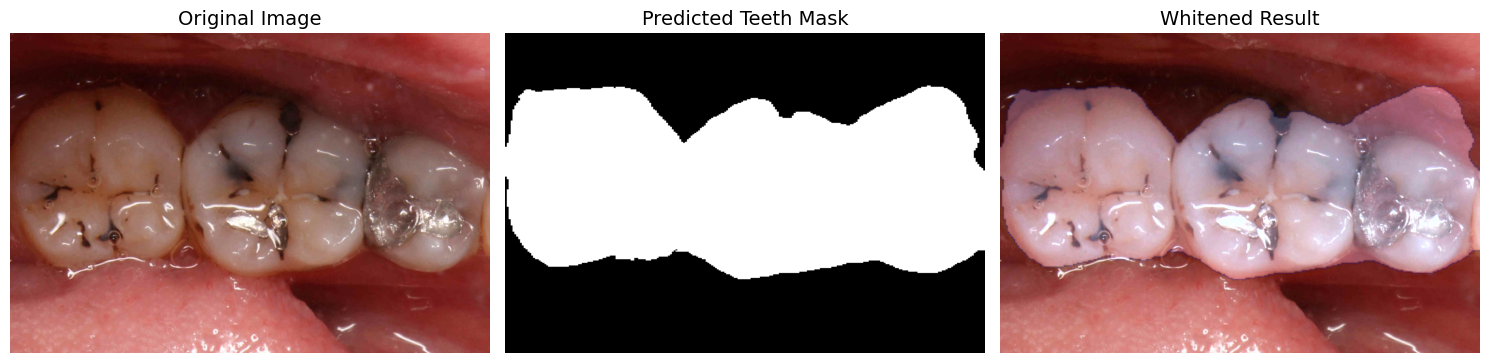

📷 Sample 1: test_0001.jpg
--------------------------------------------------


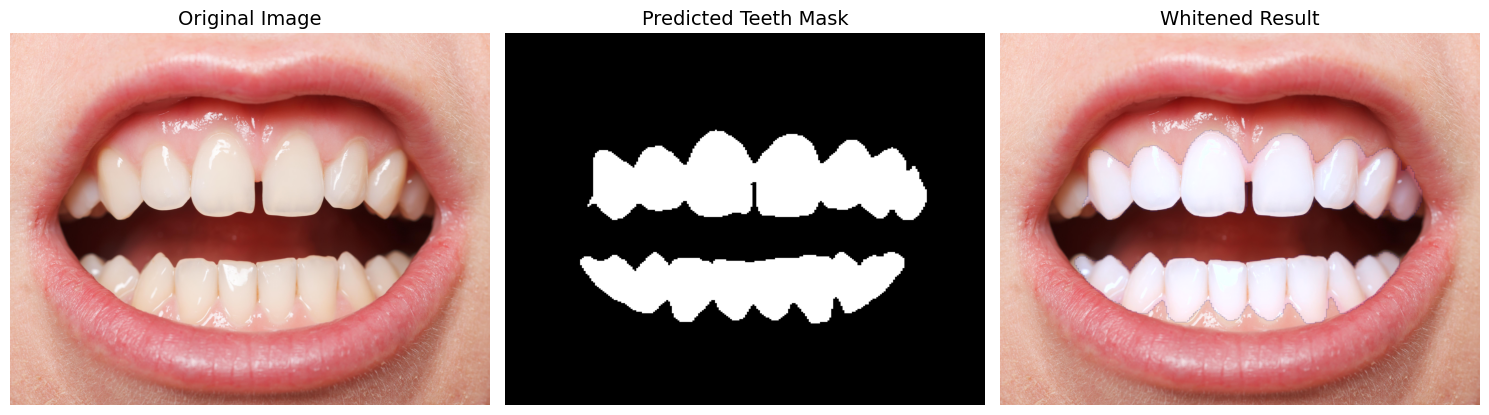

📷 Sample 2: test_0002.jpg
--------------------------------------------------


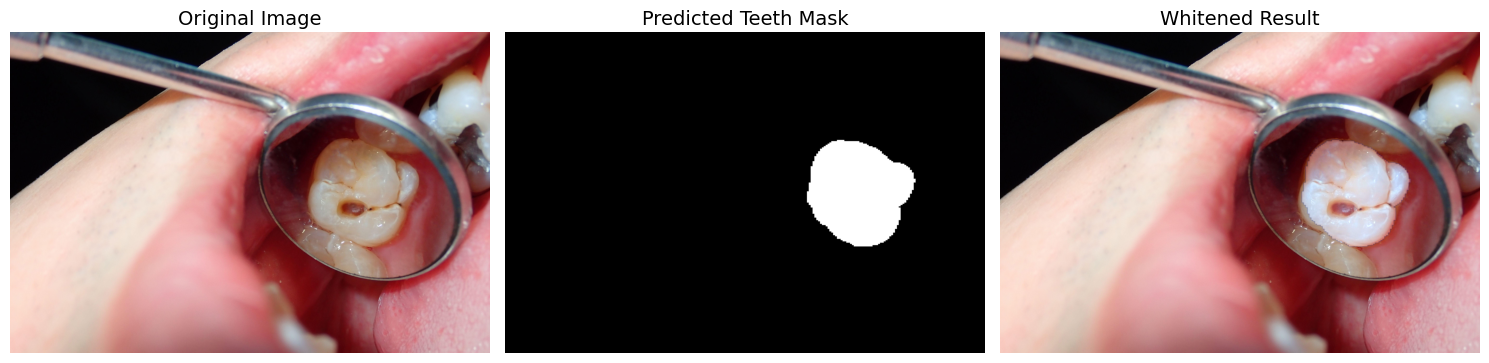

📷 Sample 3: test_0003.jpg
--------------------------------------------------


In [19]:
# Process test images (if model is loaded)
if model_loaded:
    print("\n🔄 Processing test images...")

    # Define paths
    test_input_dir = os.path.join(BASE_DATA_PATH, 'test', 'images')

    if os.path.exists(test_input_dir):
        # Process subset of test images
        batch_results = pipeline.process_directory(
            input_dir=test_input_dir,
            output_dir=RESULTS_DIR,
            max_images=10  # Limit for demonstration
        )

        # Show results summary
        print(f"\n📊 Results Summary:")
        print(f"   Total images: {batch_results['total']}")
        print(f"   Successful: {batch_results['successful']}")
        print(f"   Failed: {batch_results['failed']}")

        # Visualize sample results
        if batch_results['samples']:
            print(f"\n🖼️  Visualizing sample results...")
            pipeline.visualize_results(batch_results, num_samples=3)

    else:
        print(f"⚠️  Test directory not found: {test_input_dir}")
        print("   Please ensure dataset is properly extracted")

else:
    print("⚠️  Cannot process images - no trained model available")
    print("   Please run training first or load a pre-trained model")

Processing: content/processed_data/processed_data/test/images/test_0027.jpg
✅ Success! Result saved to: test_results/whitened_singe_test_test_0027.jpg


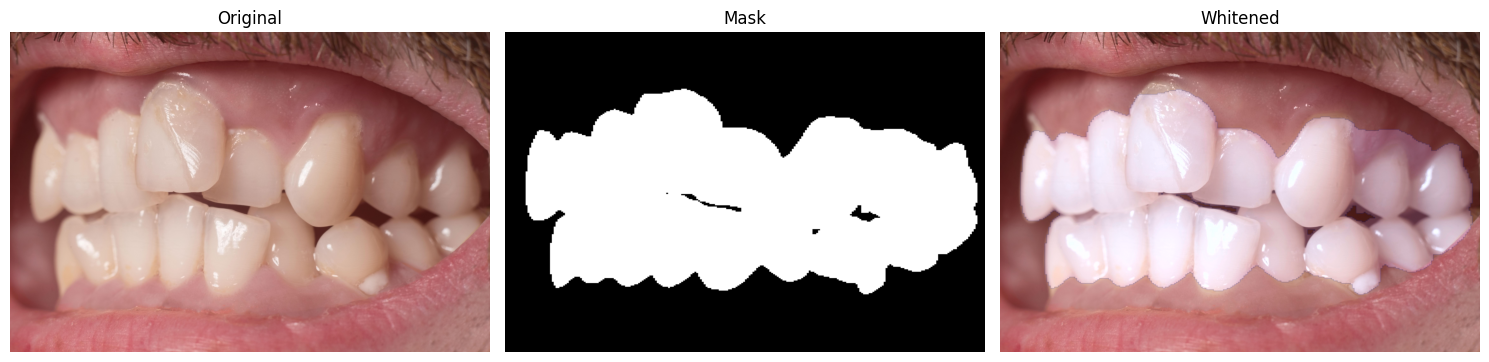

In [20]:


IMAGE_PATH = "content/processed_data/processed_data/test/images/test_0027.jpg" 
OUTPUT_PATH = f"test_results/whitened_singe_test_{IMAGE_PATH.split('/')[-1]}"  

if model_loaded and os.path.exists(IMAGE_PATH):
    print(f"Processing: {IMAGE_PATH}")

    result = pipeline.process_single_image(
        image_path=IMAGE_PATH,
        save_path=OUTPUT_PATH,
        adaptive_whitening=True,
        intensity=1.0
    )

    if result['success']:
        print(f"✅ Success! Result saved to: {OUTPUT_PATH}")

        # Visualize result
        original_rgb = cv2.cvtColor(result['original_image'], cv2.COLOR_BGR2RGB)
        whitened_rgb = cv2.cvtColor(result['whitened_image'], cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(original_rgb)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(result['predicted_mask'], cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(whitened_rgb)
        plt.title('Whitened')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(f"❌ Failed: {result['error']}")
else:
    print("⚠️  Please update IMAGE_PATH with a valid image path")



## ```For Seperate Inference/Testing You can check out Inference-whitening-pipeline.ipynb or Inference-whitening-pipeline.py```